In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import pandas as pd
import h5py
from tqdm.notebook import tqdm
import collections as cl
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold

import warnings
warnings.filterwarnings('ignore')

import random
random_state=42
random.seed(random_state)

# load embedding

In [2]:
embedding = 'vggish'
data = h5py.File('embeddings.h5', 'r')

In [3]:
###### IRMAS data ######
dataset = 'irmas'
keys_ori = list(data[dataset][embedding]['keys'])
key_clip = list(set(keys_ori))
len(key_clip)

6705

In [4]:
key_train = set(pd.read_csv('irmas_train.csv', header=None, squeeze=True))
key_test = set(pd.read_csv('irmas_test.csv', header=None, squeeze=True))

# these loops go through all sample keys, and save their row numbers to either idx_train or idx_test
idx_train, idx_test = [], []

for k in range(len(key_clip)):
    if str(key_clip[k]) in key_train:
        idx_train.append(k)
    elif str(key_clip[k]) in key_test:
        idx_test.append(k)
    else:
        # This should never happen, but better safe than sorry.
        raise RuntimeError('Unknown sample key={}! Abort!'.format(str(key_clip[k])))
        
# cast the idx_* arrays to numpy structures
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [5]:
group_matcher = re.compile(r'.*?\]\[(?P<class>\w+)\]\d.*')

def groupname(x):
    res = re.match(group_matcher, x)
    return res.groups()[0]

genres = [groupname(_) for _ in key_clip]
print(set(genres), len(genres))

{'jaz_blu', 'cou_fol', 'cla', 'lat_sou', 'pop_roc'} 6705


In [6]:
matcher = re.compile(r'.*?\[(?P<class>\w+)\].*')

def classname(x):
    res = re.match(matcher, x)
    return res.groups()[0]

instruments = [classname(_) for _ in key_clip]
print(set(instruments), len(instruments))

{'sax', 'cla', 'vio', 'cel', 'pia', 'gac', 'flu', 'voi', 'gel', 'tru', 'org'} 6705


In [7]:
instrument_align = {'cla': 'clarinet', 
                   'org': 'organ',
                   'cel': 'cello',
                   'vio': 'violin',
                   'gac': 'guitar',
                   'voi': 'voice',
                   'gel': 'guitar',
                   'sax': 'saxophone',
                   'tru': 'trumpet',
                   'pia': 'piano',
                   'flu': 'flute'}

genre_align = {'pop_roc': 'pop_roc',
            'jaz_blu': 'jazz_blue',
            'cla': 'classical',
            'cou_fol': 'country_folk',
            'lat_sou': 'latin_soul'}

In [8]:
instruments = [instrument_align[key] for key in instruments]
print(set(instruments), len(instruments))

genres = [genre_align[key] for key in genres]
print(set(genres), len(genres))

genres = np.array(genres)
instruments = np.array(instruments)
key_clip = np.array(key_clip)

{'violin', 'guitar', 'cello', 'clarinet', 'voice', 'trumpet', 'organ', 'flute', 'piano', 'saxophone'} 6705
{'latin_soul', 'classical', 'jazz_blue', 'pop_roc', 'country_folk'} 6705


In [9]:
instruments_train = instruments[idx_train]; instruments_test = instruments[idx_test]
genres_train = genres[idx_train]; genres_test = genres[idx_test]
key_clip_train = key_clip[idx_train]; key_clip_test = key_clip[idx_test]

In [10]:
genre_train_idx = genres_train != 'latin_soul'
genres_train = genres_train[genre_train_idx]
instruments_train = instruments_train[genre_train_idx]
key_clip_train = key_clip_train[genre_train_idx]

In [11]:
genre_test_idx = genres_test != 'latin_soul'
genres_test = genres_test[genre_test_idx]
instruments_test = instruments_test[genre_test_idx]
key_clip_test = key_clip_test[genre_test_idx]

In [12]:
encoder_inst = LabelEncoder()
encoder_inst.fit_transform(instruments_train)   # ori = encoder.inverse_transform(Y)

encoder_genre = LabelEncoder()
encoder_genre.fit_transform(genres_train)   

instrument_map = dict(zip(encoder_inst.classes_, encoder_inst.transform(encoder_inst.classes_)))
genre_map = dict(zip(encoder_genre.classes_, encoder_genre.transform(encoder_genre.classes_)))

with open("instrument_map.json", "w") as f:
    json.dump(instrument_map, f, default=str)

with open("genre_map.json", "w") as f:

    json.dump(genre_map, f, default=str)

In [13]:
meta_train = pd.DataFrame(columns=['instrument', 'genre', 'file_name'])
meta_train['instrument'] = instruments_train
meta_train['genre'] = genres_train
meta_train['file_name'] = key_clip_train

In [14]:
meta_test = pd.DataFrame(columns=['instrument', 'genre', 'file_name'])
meta_test['instrument'] = instruments_test
meta_test['genre'] = genres_test
meta_test['file_name'] = key_clip_test

In [15]:
cl.Counter(meta_train['genre'])

Counter({'classical': 1240,
         'pop_roc': 1853,
         'jazz_blue': 1539,
         'country_folk': 365})

In [29]:
genre_A_ratio = {'classical': 1/4, 
                'pop_roc': 3/4,
                'jazz_blue': 3/4,
                'country_folk': 1/4}

In [30]:
def AB_split(meta_all, instrument_map, genre_split, subset, genre_A_ratio):
    """equally split the data into A and B for each genre"""

    meta_split = pd.DataFrame(columns=['instrument', 'genre', 'file_name', 'subset', 'part'])

    for inst in instrument_map:
        for genre in genre_split:

            to_split = meta_all.loc[(meta_all['instrument'] == inst) & (meta_all['genre'] == genre)]['file_name'].values

            if len(to_split) > 0:
                idx_shuffle = np.array(random.sample(range(len(to_split)), len(to_split)))  # shuffle
                to_split = to_split[idx_shuffle]
                split_idx = int(len(to_split) * genre_A_ratio[genre])
                
                #### A part ####
                split_case = pd.DataFrame(columns=['instrument', 'genre', 'file_name', 'subset', 'part'])
                split_case['instrument'] = [inst] * split_idx
                split_case['genre'] = [genre] * split_idx
                split_case['file_name'] = to_split[:split_idx]
                split_case['subset'] = [subset] * split_idx
                split_case['part'] = ['A'] * split_idx

                meta_split = meta_split.append(split_case)

                #### B part ####
                split_case = pd.DataFrame(columns=['instrument', 'genre', 'file_name', 'subset', 'part'])
                split_case['instrument'] = [inst] * (len(to_split) - split_idx)
                split_case['genre'] = [genre] * (len(to_split) - split_idx)
                split_case['file_name'] = to_split[:len(to_split)-split_idx]
                split_case['subset'] = [subset] * (len(to_split) - split_idx)
                split_case['part'] = ['B'] * (len(to_split) - split_idx)

                meta_split = meta_split.append(split_case)

    return meta_split

In [31]:
meta_all = AB_split(meta_train, instrument_map, genre_map, 'train', genre_A_ratio)
meta_all = meta_all.append(AB_split(meta_test, instrument_map, genre_map, 'test', genre_A_ratio)).reset_index(drop=True)

In [32]:
meta_all

,instrument,genre,file_name,subset,part
0,cello,classical,[cel][cla]0077__1,train,A
1,cello,classical,043__[cel][nod][cla]0029__1,train,A
2,cello,classical,106__[cel][nod][cla]0028__2,train,A
3,cello,classical,013__[cel][nod][cla]0025__3,train,A
4,cello,classical,[cel][cla]0019__3,train,A
...,...,...,...,...,...
6658,voice,pop_roc,[voi][pop_roc]2520__1,test,B
6659,voice,pop_roc,[voi][pop_roc]2364__2,test,B
6660,voice,pop_roc,[voi][pop_roc]2520__3,test,B
6661,voice,pop_roc,[voi][pop_roc]2341__3,test,B


In [39]:
meta_train_pl = AB_split(meta_train, instrument_map, genre_map, 'train', genre_A_ratio)
meta_train_A = meta_train_pl[meta_train_pl['part'] == 'A']
meta_train_B = meta_train_pl[meta_train_pl['part'] == 'B']

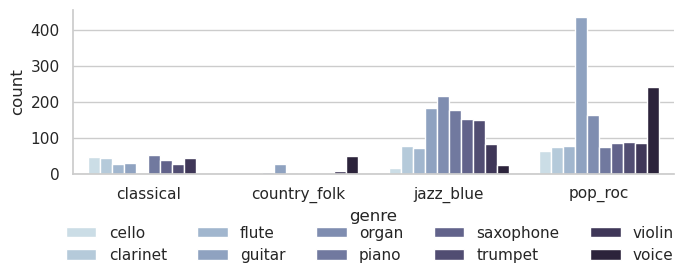

In [40]:
metcount = pd.DataFrame(columns=['instrument', 'genre', 'count'])

for inst in instrument_map:
    for genre in genre_map:
        metcount_item = pd.DataFrame(columns=['instrument', 'genre', 'count'])

        metcount_item['instrument'] = [inst]
        metcount_item['genre'] = [genre]
        metcount_item['count'] = len(meta_train_A.loc[(meta_train_A['instrument'] == inst) & (meta_train_A['genre'] == genre)])

        metcount = metcount.append(metcount_item)

sns.set_theme(context='notebook', style='whitegrid', palette='deep')
ax = sns.catplot(data=metcount, x='genre', y='count', hue='instrument', kind='bar', height=2.5, aspect=2.8,
               legend_out=False, palette="ch:s=.25,rot=-.25")
lgd = sns.move_legend(ax, "lower center", bbox_to_anchor=(.54, -.14), ncol=5, title=None, frameon=False)
# plt.savefig('results/genre_distribution.pdf', bbox_inches='tight')

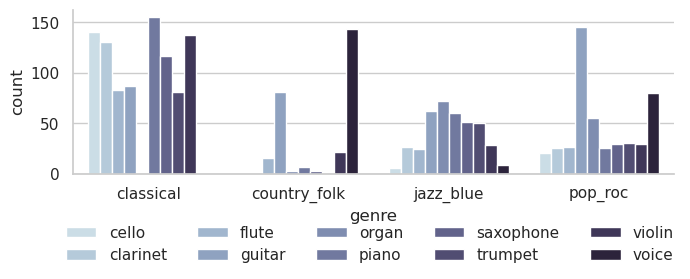

In [41]:
metcount = pd.DataFrame(columns=['instrument', 'genre', 'count'])

for inst in instrument_map:
    for genre in genre_map:
        metcount_item = pd.DataFrame(columns=['instrument', 'genre', 'count'])

        metcount_item['instrument'] = [inst]
        metcount_item['genre'] = [genre]
        metcount_item['count'] = len(meta_train_B.loc[(meta_train_B['instrument'] == inst) & (meta_train_B['genre'] == genre)])

        metcount = metcount.append(metcount_item)

sns.set_theme(context='notebook', style='whitegrid', palette='deep')
ax = sns.catplot(data=metcount, x='genre', y='count', hue='instrument', kind='bar', height=2.5, aspect=2.8,
               legend_out=False, palette="ch:s=.25,rot=-.25")
lgd = sns.move_legend(ax, "lower center", bbox_to_anchor=(.54, -.14), ncol=5, title=None, frameon=False)
# plt.savefig('results/genre_distribution.pdf', bbox_inches='tight')

In [ ]:
metcount = pd.DataFrame(columns=['instrument', 'genre', 'count'])

for inst in instrument_map:
    for genre in genre_map:
        metcount_item = pd.DataFrame(columns=['instrument', 'genre', 'count'])

        metcount_item['instrument'] = [inst]
        metcount_item['genre'] = [genre]
        metcount_item['count'] = len(meta_train_A.loc[(meta_train_A['instrument'] == inst) & (meta_train_A['genre'] == genre)])

        metcount = metcount.append(metcount_item)

sns.set_theme(context='notebook', style='whitegrid', palette='deep')
ax = sns.catplot(data=metcount, x='genre', y='count', hue='instrument', kind='bar', height=2.5, aspect=2.8,
               legend_out=False, palette="ch:s=.25,rot=-.25")
lgd = sns.move_legend(ax, "lower center", bbox_to_anchor=(.54, -.14), ncol=5, title=None, frameon=False)
# plt.savefig('results/genre_distribution.pdf', bbox_inches='tight')

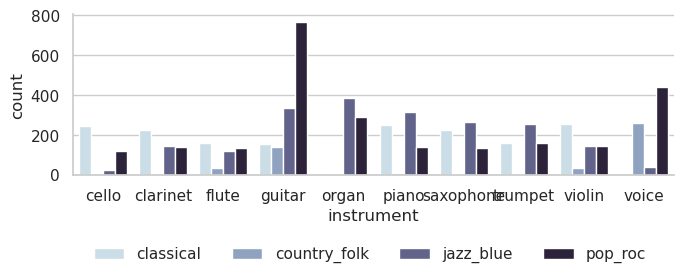

In [35]:
sns.set_theme(context='notebook', style='whitegrid', palette='deep')
ax = sns.catplot(data=metcount, x='instrument', y='count', hue='genre', kind='bar', height=2.5, aspect=2.8,
               legend_out=False, palette="ch:s=.25,rot=-.25")
lgd = sns.move_legend(ax, "lower center", bbox_to_anchor=(.54, -.14), ncol=5, title=None, frameon=False)
# plt.savefig('results/genre_distribution.pdf', bbox_inches='tight')

In [34]:
meta_all.to_csv('irmas_meta_all.csv', index=None)